# Doc2Vec

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm_notebook as tqdm

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phraser
from gensim.models import Phrases
import spacy

from MulticoreTSNE import MulticoreTSNE as TSNE
#from umap import UMAP
from sklearn.cluster import KMeans#, AgglomerativeClustering, DBSCAN, Birch
#from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.externals import joblib

np.random.seed(23)

def load_data():
    data_path = Path('./data')
    print('loading ./data/text_filtered_big.csv into dataframe')
    df = pd.read_csv(data_path/'text_filtered_big.csv',index_col=0)
    print('done')
    return df

def elbow_plot(X,model_type='k-means',max_clusters=10):
    num_clusters = np.arange(1,max_clusters+1)
    scores = []
    for num in tqdm(num_clusters):
        if model_type=='k-means':
            model = KMeans(n_clusters=num, n_jobs=-1)
        elif model_type=='GMM':
            model = GaussianMixture(n_components=num, covariance_type='full')
        elif model_type=='BGMM':
            model = BayesianGaussianMixture(n_components=num, covariance_type='full')
        model.fit(X)
        scores += [-model.score(X)]        
    plt.plot(np.arange(1,max_clusters+1),scores)
    plt.xlim(0,max_clusters)
    plt.xticks(np.arange(1,max_clusters+1))
    plt.xlabel('number of clusters')
    plt.ylabel('loss')
    plt.title(model_type+' elbow plot')
    plt.show()
    
def plot_reduced_2D(X_dr, dr_type):
    _,ax = plt.subplots(figsize=(8,8))
    ax.scatter(X_dr[:,0],X_dr[:,1],s=0.5,alpha=0.5)
    ax.set_title(dr_type+' with 2 components')
    plt.show()
    
def plot_clusters(X,yhat,model_type):
    _,ax = plt.subplots(figsize=(8,8))
    num_clusters = len(np.unique(yhat))
    for i in range(num_clusters):
        if not np.any(yhat == i):
            continue
        ax.scatter(X[yhat == i, 0], X[yhat == i, 1], s=1., cmap='Dark2')
    ax.set_title(model_type+': '+str(num_clusters)+' clusters')
    plt.show()

In [4]:
df = load_data().drop_duplicates()
nlp = spacy.load('en')
df['text_processed'] = df.text.apply(lambda x: ' '.join(word for word in simple_preprocess(x)))# if word not in stop_words))
df['tokens'] = df.text_processed.apply(lambda x:' '.join(token.text for token in nlp.tokenizer(x)))
df.head()

loading ./data/text_filtered_big.csv into dataframe
done


,text,text_processed,tokens
4,"Marjory Stoneman Douglas High has fences, gate...",marjory stoneman douglas high has fences gates...,marjory stoneman douglas high has fences gates...
7,Two People Passed Away In Front Of Me: Survivo...,two people passed away in front of me survivor...,two people passed away in front of me survivor...
9,A beloved football coach. A swimmer who had ju...,beloved football coach swimmer who had just wo...,beloved football coach swimmer who had just wo...
14,The latest on the Parkland school shooting Sto...,the latest on the parkland school shooting sto...,the latest on the parkland school shooting sto...
16,"In an emotional speech Saturday, Emma Gonzalez...",in an emotional speech saturday emma gonzalez ...,in an emotional speech saturday emma gonzalez ...


In [5]:
texts = [row.split() for row in df.tokens]
bigram = Phrases(texts)
bigram_model = Phraser(bigram)
texts = [bigram_model[doc] for doc in texts]
documents = [TaggedDocument(doc, [i]) for i,doc in enumerate(texts)]

In [65]:
doc2vec = Doc2Vec(workers=4,seed=23)#vector_size=100,negative=5,hs=0,dm=1,min_count=3,sample=0,max_vocab_size=None,alpha=0.65, 
                #min_alpha=0.065,workers=4)
doc2vec.build_vocab(documents)
doc2vec.corpus_count

3977

In [66]:
if not Path('./data/doc2vec.model').exists():
    for epoch in tqdm(range(10)):
        doc2vec.train(documents,total_examples=doc2vec.corpus_count,epochs=1)
        doc2vec.alpha -= 0.0002
        doc2vec.min_alpha = doc2vec.alpha
    doc2vec.save(str(Path('./data')/'doc2vec.model'))
else:
    doc2vec = Doc2Vec.load(str(Path('./data')/'doc2vec.model'))

In [67]:
doc2vec.wv.most_similar('cruz')

[('mr_cruz', 0.8464585542678833),
 ('cruzs', 0.733302891254425),
 ('nikolas_cruz', 0.6847975254058838),
 ('zachary_cruz', 0.5774866342544556),
 ('suspect', 0.5694514513015747),
 ('nikolas_cruzs', 0.49198102951049805),
 ('nikolas', 0.4443032741546631),
 ('without_bail', 0.4423788785934448),
 ('joshua_charo', 0.4410775303840637),
 ('lynda_cruz', 0.43457579612731934)]

In [68]:
vecs = [doc2vec.infer_vector(text) for text in texts]

In [69]:
doc2vec.docvecs.most_similar([vecs[0]])

[(0, 0.9077260494232178),
 (3350, 0.8954859972000122),
 (3632, 0.6459028124809265),
 (1136, 0.6246030330657959),
 (2911, 0.6200193166732788),
 (2557, 0.6188308000564575),
 (2458, 0.6179832816123962),
 (432, 0.6115809082984924),
 (3071, 0.5972328186035156),
 (2154, 0.596787691116333)]

# Clustering

In [70]:
X = np.array(vecs)
X.shape

(3977, 100)

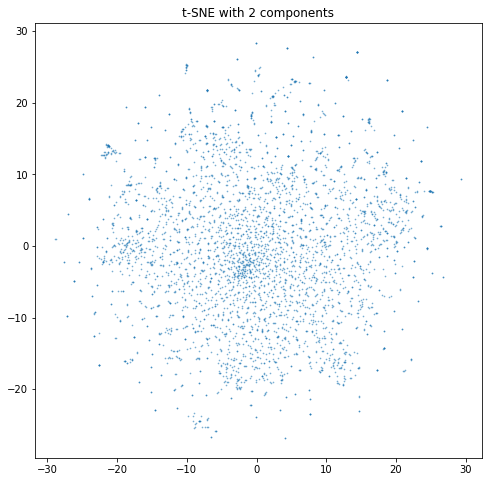

In [71]:
tsne = TSNE(n_components=2, metric='cosine',n_jobs=4)
X_tsne = tsne.fit_transform(X)
plot_reduced_2D(X_tsne, 't-SNE')

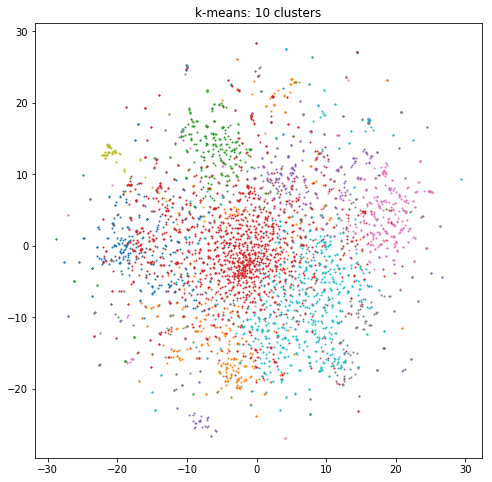

In [92]:
#elbow_plot(X,model_type='k-means',max_clusters=20)
model = KMeans(n_clusters=10,n_jobs=-1)
model.fit(X)
yhat = model.predict(X)    
plot_clusters(X_tsne,yhat,'k-means')

In [96]:
centers = model.cluster_centers_
centers.shape

(10, 100)